Q1: Write a CUDA C/C++ program to perform element-wise addi on of two
vectors.                                        
C[i]=A[i]+B[i]
Given: Vector size: N = 1024

In [ ]:
%%writefile vectoradd.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define N 1024

__global__ void addvector(float *A,float *B, float *C){
  int i = blockIdx.x * blockDim.x + threadIdx.x;

  if(i<N){
    C[i] = A[i] + B[i];
  }
};

int main(){
  float h_A[N], h_B[N], h_C[N];
  float *d_A, *d_B, *d_C;

  for(int i=0;i<N;i++){
    h_A[i] = i;
    h_B[i] = 2*i;
}
cudaMalloc((void **)&d_A,N*sizeof(float));
cudaMalloc((void **)&d_B,N*sizeof(float));
cudaMalloc((void **)&d_C,N*sizeof(float));

cudaMemcpy(d_A,h_A,N*sizeof(float),cudaMemcpyHostToDevice);
cudaMemcpy(d_B,h_B,N*sizeof(float),cudaMemcpyHostToDevice);
cudaMemcpy(d_C,h_C,N*sizeof(float),cudaMemcpyHostToDevice);

int threadsPerBlock = 256;
int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

addvector<<<blocksPerGrid,threadsPerBlock>>>(d_A,d_B,d_C);

cudaMemcpy(h_C,d_C,N*sizeof(float),cudaMemcpyDeviceToHost);

for(int i = 0; i < 10; i++)
    {
        printf("h_C[%d] = %f\n", i, h_C[i]);
    }

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

return 0;
}

Writing vectoradd.cu


In [ ]:
!nvcc -arch=sm_75 vectoradd.cu -o add

In [ ]:
!./add

h_C[0] = 0.000000
h_C[1] = 3.000000
h_C[2] = 6.000000
h_C[3] = 9.000000
h_C[4] = 12.000000
h_C[5] = 15.000000
h_C[6] = 18.000000
h_C[7] = 21.000000
h_C[8] = 24.000000
h_C[9] = 27.000000


Q2: Perform the same vector addi on as in Q1 using Thrust library only.

In [ ]:
%%writefile vecAdd_thrust.cu
#include <iostream>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/functional.h>

#define N 1024

int main()
{
    // Host vectors
    thrust::host_vector<float> h_A(N);
    thrust::host_vector<float> h_B(N);

    // Initialize vectors
    for(int i = 0; i < N; i++)
    {
        h_A[i] = i;
        h_B[i] = 2 * i;
    }

    // Copy to device (GPU)
    thrust::device_vector<float> d_A = h_A;
    thrust::device_vector<float> d_B = h_B;
    thrust::device_vector<float> d_C(N);

    // Perform vector addition on GPU
    thrust::transform(
        d_A.begin(),
        d_A.end(),
        d_B.begin(),
        d_C.begin(),
        thrust::plus<float>()
    );

    // Copy result back to host
    thrust::host_vector<float> h_C = d_C;

    // Print first 10 results
    for(int i = 0; i < 10; i++)
    {
        std::cout << "C[" << i << "] = " << h_C[i] << std::endl;
    }

    return 0;
}

Overwriting vecAdd_thrust.cu


In [ ]:
!nvcc -arch=sm_75 vecAdd_thrust.cu -o thrust

In [ ]:
!./thrust

C[0] = 0
C[1] = 3
C[2] = 6
C[3] = 9
C[4] = 12
C[5] = 15
C[6] = 18
C[7] = 21
C[8] = 24
C[9] = 27


Q3: Compute the dot product of two vectors of size, N =1024: Result=∑A[i]×B[i]
using Thrust and compare its performance with that on CPU.

In [ ]:
%%writefile vecdot_thrust.cu
#include <iostream>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/inner_product.h>
#include <thrust/functional.h>

#define N 1024

int main()
{
    // Host vectors
    thrust::host_vector<float> h_A(N);
    thrust::host_vector<float> h_B(N);

    // Initialize vectors
    for(int i = 0; i < N; i++)
    {
        h_A[i] = i;
        h_B[i] = 2 * i;
    }

    // Copy to device (GPU)
    thrust::device_vector<float> d_A = h_A;
    thrust::device_vector<float> d_B = h_B;

    // Perform vector dot product on GPU
    float result = thrust::inner_product(
        d_A.begin(),
        d_A.end(),
        d_B.begin(),
        0.0f
    );

    std::cout << "Dot product = " << result << std::endl;


    return 0;
}

Overwriting vecdot_thrust.cu


In [ ]:
!nvcc -arch=sm_75 vecdot_thrust.cu -o dot

In [ ]:
!./dot

Dot product = 7.1478e+08


Q4: Write a CUDA kernel for matrix mul plica on: C=A×B where Matrix size is 16
X 16. Explain why matrix mul plica on needs more computa on than
addi on (as in Q1).

In [6]:
%%writefile matrix_mul.cu

#include <stdio.h>

#define N 16

// CUDA kernel
__global__ void matrixMul(float *A, float *B, float *C)
{
    int row = threadIdx.y;
    int col = threadIdx.x;

    float sum = 0.0;

    for(int k = 0; k < N; k++)
    {
        sum += A[row*N + k] * B[k*N + col];
    }

    C[row*N + col] = sum;
}

int main()
{
    float A[N*N], B[N*N], C[N*N];

    for(int i=0;i<N*N;i++)
    {
        A[i] = 1.0;
        B[i] = 1.0;
    }

    float *d_A,*d_B,*d_C;

    cudaMalloc(&d_A, N*N*sizeof(float));
    cudaMalloc(&d_B, N*N*sizeof(float));
    cudaMalloc(&d_C, N*N*sizeof(float));

    cudaMemcpy(d_A, A, N*N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, N*N*sizeof(float), cudaMemcpyHostToDevice);

    dim3 threads(N,N);
    matrixMul<<<1,threads>>>(d_A,d_B,d_C);

    cudaMemcpy(C, d_C, N*N*sizeof(float), cudaMemcpyDeviceToHost);

    printf("First 16 entries of C:\n");

   for(int i = 0; i < 16; i++)
   {
    printf("%f ", C[i]);
    }
    printf("\n");


    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}

Overwriting matrix_mul.cu


In [7]:
!nvcc -arch=sm_75 matrix_mul.cu -o matrix_mul

In [8]:
!./matrix_mul

First 16 entries of C:
16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 16.000000 


Q5:  For vector addi on of size 5,000,000, implement and compare:
• CPU sequen al C/C++ program
• CUDA kernel implementa on
• Thrust implementa on
• RAPIDS implementa on
Measure execu on me and compare complexity for each approach and
present results in a table. Plot comparison graph.

In [48]:
import numpy as np
import time

N = 5000000

A = np.ones(N)
B = np.ones(N)*2

start = time.time()

C = A + B

end = time.time()
CPU_time = (end-start)*1000

print("CPU time (ms):", CPU_time)

CPU time (ms): 16.538619995117188


In [49]:
%%writefile vectoradd_cuda.cu
#include <stdio.h>
#include <time.h>

#define N 5000000

__global__ void vecAdd(float *A, float *B, float *C)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if(i < N)
        C[i] = A[i] + B[i];
}

int main()
{
    float *A,*B,*C;
    float *d_A,*d_B,*d_C;

    A=(float*)malloc(N*sizeof(float));
    B=(float*)malloc(N*sizeof(float));
    C=(float*)malloc(N*sizeof(float));

    for(int i=0;i<N;i++){ A[i]=1; B[i]=2; }

    cudaMalloc(&d_A,N*sizeof(float));
    cudaMalloc(&d_B,N*sizeof(float));
    cudaMalloc(&d_C,N*sizeof(float));

    cudaMemcpy(d_A,A,N*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(d_B,B,N*sizeof(float),cudaMemcpyHostToDevice);

    // START TIME
    clock_t start = clock();

    vecAdd<<<(N+255)/256,256>>>(d_A,d_B,d_C);

    cudaDeviceSynchronize();

    // END TIME
    clock_t end = clock();

    double CUDA_time = (double)(end-start)*1000/CLOCKS_PER_SEC;

    printf("%f", CUDA_time);

    cudaMemcpy(C,d_C,N*sizeof(float),cudaMemcpyDeviceToHost);
}


Overwriting vectoradd_cuda.cu


In [50]:
!nvcc -arch=sm_75 vectoradd_cuda.cu -o vec_add

In [51]:
!./vec_add

0.343000

In [52]:
import subprocess

CUDA_time = float(
    subprocess.check_output("./vec_add").decode().strip()
)

print(float(CUDA_time))

0.348


In [53]:
import cupy as cp
import time

N = 5000000

A = cp.ones(N)
B = cp.ones(N)*2

start = time.time()

C = A + B

cp.cuda.Stream.null.synchronize()

end = time.time()
Thrust_time  = (end-start)*1000

print("Thrust-like GPU time (ms):",Thrust_time)


Thrust-like GPU time (ms): 1.1935234069824219


In [56]:
import cudf
import cupy as cp
import time

N = 5000000

A = cp.ones(N)
B = cp.ones(N)*2

start = time.time()

C = A + B

cp.cuda.Stream.null.synchronize()

end = time.time()
RAPIDS_time = (end-start)*1000

print("RAPIDS time (ms):",RAPIDS_time)


RAPIDS time (ms): 1.1029243469238281


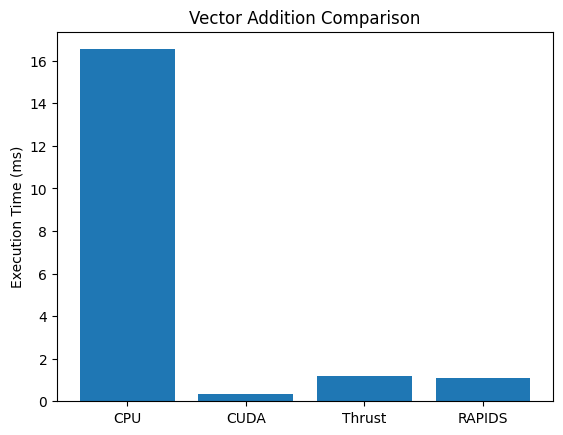

In [57]:
import matplotlib.pyplot as plt

methods = ["CPU","CUDA","Thrust","RAPIDS"]
times = [CPU_time, CUDA_time, Thrust_time, RAPIDS_time]

plt.bar(methods,times)
plt.ylabel("Execution Time (ms)")
plt.title("Vector Addition Comparison")
plt.show()


Q6:Write a CUDA C++ program using the Thrust library to compute the sum of
all elements in a vector stored on the GPU. The vector is of size 10 and it
should be ini alized with values 1,…..10.  

In [58]:
%%writefile thrust_sum.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/reduce.h>

int main()
{
    const int N = 10;

    // Create vector on GPU
    thrust::device_vector<int> vec(N);

    // Initialize values 1..10
    for(int i=0;i<N;i++)
        vec[i] = i + 1;

    // Compute sum using thrust reduce
    int sum = thrust::reduce(vec.begin(), vec.end(), 0, thrust::plus<int>());

    std::cout << "Sum = " << sum << std::endl;

    return 0;
}


Writing thrust_sum.cu


In [60]:
!nvcc -arch=sm_75 thrust_sum.cu -o thrust_sum

In [61]:
!./thrust_sum

Sum = 55


 Q7: Write a CUDA C++ program using Thrust to sort (ascending) a vector of
integers on the GPU. Consider vector size 8 with following values: 7, 2, 9, 1,
5, 3, 8, 4. Print the vector before and a er sor ng.

In [62]:
%%writefile thrust_sort.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/sort.h>

int main()
{
    // Vector size = 8
    int arr[8] = {7, 2, 9, 1, 5, 3, 8, 4};

    // Create device vector and copy data to GPU
    thrust::device_vector<int> vec(arr, arr+8);

    // Print before sorting
    std::cout << "Before sorting: ";
    for(int i=0;i<8;i++)
        std::cout << vec[i] << " ";
    std::cout << std::endl;

    // Sort ascending
    thrust::sort(vec.begin(), vec.end());

    // Print after sorting
    std::cout << "After sorting: ";
    for(int i=0;i<8;i++)
        std::cout << vec[i] << " ";
    std::cout << std::endl;

    return 0;
}


Writing thrust_sort.cu


In [63]:
!nvcc -arch=sm_75 thrust_sort.cu -o thrust_sort

In [64]:
!./thrust_sort

Before sorting: 7 2 9 1 5 3 8 4 
After sorting: 1 2 3 4 5 7 8 9 
